In [60]:
import torch
import clip
import numpy as np
import matplotlib.pyplot as plt
import os
import math
from torchvision.datasets import CIFAR10
from torchvision.transforms import *
from tqdm.notebook import tqdm
import argparse
import numpy as np
import os
import sys
import tabulate
import time
import torch
import torch.nn.functional as F
import train_utils
import torch.nn as nn
import data
import torchvision.models as models
import utils
import clip
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [61]:
%env 'CUDA_VISIBLE_DEVICES'='2'

env: 'CUDA_VISIBLE_DEVICES'='2'


In [62]:
value = os.getenv('CUDA_VISIBLE_DEVICES')
print(value)

2


In [63]:
dataset = 'CIFAR10'
data_path = '/home/santoshsanjeev/dnn-mode-connectivity/'
batch_size = 128
num_workers = 4
transform = 'CLIP'
use_test = True
seed = 1

torch.backends.cudnn.benchmark = True
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)


In [64]:

loaders, num_classes,classnames = data.loaders(
    dataset,
    data_path,
    batch_size,
    num_workers,
    transform,
    use_test,
    dataset_selection='clip_cifar10'
)

dataset_selection
Files already downloaded and verified
5000 45000
Files already downloaded and verified


In [65]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    # Get the current device ID
    device_id = torch.cuda.current_device()
    print(f"Current GPU ID: {device_id}")
else:
    print("CUDA is not available.")

Current GPU ID: 2


In [66]:
import torch

# Set the desired GPU device ID
device_id = 2

# Check if CUDA is available
if torch.cuda.is_available():
    # Set the device to use GPU ID 2
    torch.cuda.set_device(device_id)
    print(f"Changed PyTorch GPU Device ID to {device_id}")
else:
    print("CUDA is not available.")

Changed PyTorch GPU Device ID to 2


INITIAL MODELS

In [67]:
import os
template = train_utils.openai_imagenet_template
test_results = []
folder_path = '/share/nvmedata/santosh/model_soups/models_model_soups/cifar10_model_soups_models/'

# List all files in the directory
files = os.listdir(folder_path)

# Filter files ending with '.pt'
model_files = [file for file in files if file.endswith('.pt')]
model_files.sort()
print(model_files)

['checkpoint_10.1.pt', 'checkpoint_10.2.pt', 'checkpoint_10.3.pt', 'checkpoint_10.4.pt', 'checkpoint_10.5.pt']


In [68]:
device = 'cuda:2' if torch.cuda.is_available() else 'cpu'
state_dicts = []

for f in model_files:
    model_path = os.path.join(folder_path, f)
    state_dicts.append(torch.load(model_path, map_location=device))

In [69]:
val_results = []
for model_file in model_files:
    model_path = os.path.join(folder_path, model_file)

    # Load each model
    pre_model, _ = clip.load('ViT-B/32',device='cuda:2')
    checkpoint = torch.load(model_path,map_location='cuda:2')
    criterion = F.cross_entropy

    feature_dim = checkpoint['classification_head.weight'].shape[1]
    num_classes = checkpoint['classification_head.weight'].shape[0]
    normalize = True
    clf = train_utils.zeroshot_classifier(pre_model, classnames, template, 'cuda:2')
    model = train_utils.ModelWrapper(pre_model, feature_dim, num_classes, normalize, clf)
    model.load_state_dict(checkpoint)
    
    for pp in model.parameters():
        pp.data = pp.data.float()
    
    model = model.to('cuda:2')

    test_res = utils.test(loaders['val'], model, criterion)
    print(f'Model: {model_file}, Accuracy: {test_res["accuracy"]}')
    val_results.append(test_res["accuracy"])
print(val_results)

Building zero-shot classifier.


100%|██████████| 10/10 [00:00<00:00, 40.76it/s]


Model: checkpoint_10.1.pt, Accuracy: 98.26
Building zero-shot classifier.


100%|██████████| 10/10 [00:00<00:00, 40.37it/s]


Model: checkpoint_10.2.pt, Accuracy: 97.66
Building zero-shot classifier.


100%|██████████| 10/10 [00:00<00:00, 40.38it/s]


Model: checkpoint_10.3.pt, Accuracy: 98.34
Building zero-shot classifier.


100%|██████████| 10/10 [00:00<00:00, 40.55it/s]


Model: checkpoint_10.4.pt, Accuracy: 97.22
Building zero-shot classifier.


100%|██████████| 10/10 [00:00<00:00, 40.17it/s]


Model: checkpoint_10.5.pt, Accuracy: 98.16
[98.26, 97.66, 98.34, 97.22, 98.16]


In [70]:
for model_file in model_files:
    model_path = os.path.join(folder_path, model_file)

    # Load each model
    pre_model, _ = clip.load('ViT-B/32',device='cuda:2')
    checkpoint = torch.load(model_path,map_location='cuda:2')
    criterion = F.cross_entropy

    feature_dim = checkpoint['classification_head.weight'].shape[1]
    num_classes = checkpoint['classification_head.weight'].shape[0]
    normalize = True
    clf = train_utils.zeroshot_classifier(pre_model, classnames, template, 'cuda:2')
    model = train_utils.ModelWrapper(pre_model, feature_dim, num_classes, normalize, clf)
    model.load_state_dict(checkpoint)
    
    for pp in model.parameters():
        pp.data = pp.data.float()
    
    model = model.to('cuda:2')

    test_res = utils.test(loaders['test'], model, criterion)
    print(f'Model: {model_file}, Accuracy: {test_res["accuracy"]}')
    test_results.append(test_res["accuracy"])

Building zero-shot classifier.


100%|██████████| 10/10 [00:00<00:00, 40.25it/s]


Model: checkpoint_10.1.pt, Accuracy: 97.7
Building zero-shot classifier.


100%|██████████| 10/10 [00:00<00:00, 40.29it/s]


Model: checkpoint_10.2.pt, Accuracy: 97.24
Building zero-shot classifier.


100%|██████████| 10/10 [00:00<00:00, 40.33it/s]


Model: checkpoint_10.3.pt, Accuracy: 98.04
Building zero-shot classifier.


100%|██████████| 10/10 [00:00<00:00, 40.53it/s]


Model: checkpoint_10.4.pt, Accuracy: 96.51
Building zero-shot classifier.


100%|██████████| 10/10 [00:00<00:00, 40.55it/s]


Model: checkpoint_10.5.pt, Accuracy: 97.83


In [71]:
print(len(state_dicts), test_results)

5 [97.7, 97.24, 98.04, 96.51, 97.83]


([0, 1, 2, 3, 4],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

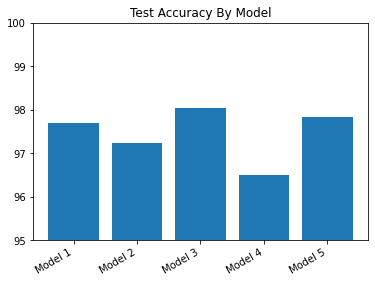

In [72]:
names = [f'Model {i+1}' for i in range(len(state_dicts))]
plt.bar(names, test_results)
plt.title("Test Accuracy By Model")
plt.ylim([95,100])
plt.xticks(rotation=30, ha='right')

INITIAL_MODELS_UNIFORM_SOUP

In [73]:
def get_model(state_dicts, alphal):
  model, _ = clip.load('ViT-B/32')
  feature_dim = state_dicts[0]['classification_head.weight'].shape[1]
  num_classes = state_dicts[0]['classification_head.weight'].shape[0]
  normalize = True
  model = train_utils.ModelWrapper(model, feature_dim, num_classes, normalize)
  sd = {k : state_dicts[0][k].clone() * alphal[0] for k in state_dicts[0].keys()}
  for i in range(1, len(state_dicts)):
      for k in state_dicts[i].keys():
          sd[k] = sd[k] + state_dicts[i][k].clone() * alphal[i]
  model.load_state_dict(sd)
  model = model.to(device)
  return model

In [74]:
print(names, test_results)

['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5'] [97.7, 97.24, 98.04, 96.51, 97.83]


Model: 6, Accuracy: 98.39


([0, 1, 2, 3, 4, 5],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

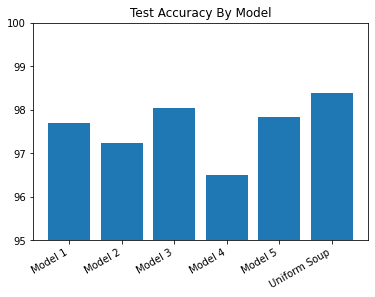

In [75]:
alphal = [1 / len(state_dicts) for i in range(len(state_dicts))]
model = get_model(state_dicts, alphal)
test_res = utils.test(loaders['test'], model, criterion)
print(f'Model: {6}, Accuracy: {test_res["accuracy"]}')
test_results.append(test_res["accuracy"])
names.append("Uniform Soup")
plt.bar(names, test_results)
plt.title("Test Accuracy By Model")
plt.ylim([95,100])
plt.xticks(rotation=30, ha='right')

In [76]:
ranked_candidates = [i for i in range(len(state_dicts))]
ranked_candidates.sort(key=lambda x: -val_results[x])

current_best = val_results[ranked_candidates[0]]
best_ingredients = ranked_candidates[:1]
for i in range(1, len(state_dicts)):
  # add current index to the ingredients
  ingredient_indices = best_ingredients \
    + [ranked_candidates[i]]
  alphal = [0 for i in range(len(state_dicts))]
  for j in ingredient_indices:
    alphal[j] = 1 / len(ingredient_indices)
  
  # benchmark and conditionally append
  model = get_model(state_dicts, alphal)
  test_res = utils.test(loaders['val'], model, criterion)
  current = test_res['accuracy']
  print(f'Models {ingredient_indices} got {current}% on validation.')
  if current > current_best:
    current_best = current
    best_ingredients = ingredient_indices


Models [2, 0] got 98.7% on validation.
Models [2, 0, 4] got 98.88% on validation.
Models [2, 0, 4, 1] got 98.84% on validation.
Models [2, 0, 4, 3] got 98.84% on validation.


In [77]:
alphal = [0 for i in range(len(state_dicts))]
for j in best_ingredients:
  alphal[j] = 1 / len(best_ingredients)
model = get_model(state_dicts, alphal)
test_res = utils.test(loaders['test'], model, criterion)

test_results.append(test_res['accuracy'])

In [79]:
print(names, test_results)

['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5', 'Uniform Soup'] [97.7, 97.24, 98.04, 96.51, 97.83, 98.39, 98.45]


([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

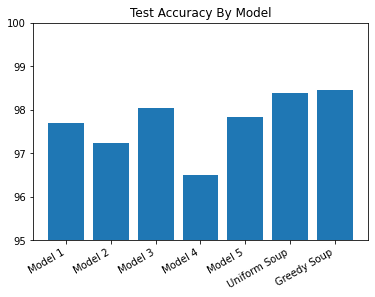

In [81]:
names.append("Greedy Soup")
plt.bar(names, test_results)
plt.title("Test Accuracy By Model")
plt.ylim([95,100])
plt.xticks(rotation=30, ha='right')

MODEL-1

In [89]:
import os
template = train_utils.openai_imagenet_template
test_results = []
folder_path = '/share/nvmedata/santosh/model_soups/models_model_soups/fge_clip_ensemble/fge_cifar_clip_checkpoint_1_e-6_v2'

# List all files in the directory
files = os.listdir(folder_path)

# Filter files ending with '.pt'
model_files = [file for file in files if file.endswith('.pt')]
model_files.sort()
print(model_files)

['checkpoint_10.1.pt', 'fge-11.pt', 'fge-13.pt', 'fge-15.pt', 'fge-17.pt', 'fge-19.pt', 'fge-21.pt', 'fge-23.pt', 'fge-25.pt', 'fge-27.pt', 'fge-29.pt']


In [90]:
device = 'cuda:2' if torch.cuda.is_available() else 'cpu'
state_dicts = []

for f in model_files:
    model_path = os.path.join(folder_path, f)
    if f.startswith('checkpoint'):
        state_dicts.append(torch.load(model_path, map_location=device))    
    else:
        state_dicts.append(torch.load(model_path, map_location=device)['model_state'])


val_results = []
for model_file in model_files:
    if model_file.startswith('checkpoint'):
        model_path = os.path.join(folder_path, model_file)
        # Load each model
        pre_model, _ = clip.load('ViT-B/32',device='cuda:2')
        checkpoint = torch.load(model_path,map_location='cuda:2')
    else:
        model_path = os.path.join(folder_path, model_file)
        pre_model, _ = clip.load('ViT-B/32',device='cuda:2')
        checkpoint = torch.load(model_path,map_location='cuda:2')
        checkpoint = checkpoint['model_state']
    criterion = F.cross_entropy
    feature_dim = checkpoint['classification_head.weight'].shape[1]
    num_classes = checkpoint['classification_head.weight'].shape[0]
    normalize = True
    clf = train_utils.zeroshot_classifier(pre_model, classnames, template, 'cuda:2')
    model = train_utils.ModelWrapper(pre_model, feature_dim, num_classes, normalize, clf)
    model.load_state_dict(checkpoint)
    
    for pp in model.parameters():
        pp.data = pp.data.float()
    
    model = model.to('cuda:2')

    test_res = utils.test(loaders['val'], model, criterion)
    print(f'Model: {model_file}, Accuracy: {test_res["accuracy"]}')
    val_results.append(test_res["accuracy"])
print(val_results)

Building zero-shot classifier.


100%|██████████| 10/10 [00:00<00:00, 36.12it/s]


Model: checkpoint_10.1.pt, Accuracy: 98.26
Building zero-shot classifier.


100%|██████████| 10/10 [00:00<00:00, 40.74it/s]


Model: fge-11.pt, Accuracy: 98.32
Building zero-shot classifier.


100%|██████████| 10/10 [00:00<00:00, 40.68it/s]


Model: fge-13.pt, Accuracy: 98.36
Building zero-shot classifier.


100%|██████████| 10/10 [00:00<00:00, 40.22it/s]


Model: fge-15.pt, Accuracy: 98.36
Building zero-shot classifier.


100%|██████████| 10/10 [00:00<00:00, 40.60it/s]


Model: fge-17.pt, Accuracy: 98.36
Building zero-shot classifier.


100%|██████████| 10/10 [00:00<00:00, 40.39it/s]


Model: fge-19.pt, Accuracy: 98.38
Building zero-shot classifier.


100%|██████████| 10/10 [00:00<00:00, 40.63it/s]


Model: fge-21.pt, Accuracy: 98.36
Building zero-shot classifier.


100%|██████████| 10/10 [00:00<00:00, 40.49it/s]


Model: fge-23.pt, Accuracy: 98.36
Building zero-shot classifier.


100%|██████████| 10/10 [00:00<00:00, 40.39it/s]


Model: fge-25.pt, Accuracy: 98.32
Building zero-shot classifier.


100%|██████████| 10/10 [00:00<00:00, 40.41it/s]


Model: fge-27.pt, Accuracy: 98.3
Building zero-shot classifier.


100%|██████████| 10/10 [00:00<00:00, 40.50it/s]


Model: fge-29.pt, Accuracy: 98.28
[98.26, 98.32, 98.36, 98.36, 98.36, 98.38, 98.36, 98.36, 98.32, 98.3, 98.28]


In [91]:
for model_file in model_files:
    model_path = os.path.join(folder_path, model_file)

    # Load each model
    if model_file.startswith('checkpoint'):
        model_path = os.path.join(folder_path, model_file)
        # Load each model
        pre_model, _ = clip.load('ViT-B/32',device='cuda:2')
        checkpoint = torch.load(model_path,map_location='cuda:2')
    else:
        model_path = os.path.join(folder_path, model_file)
        pre_model, _ = clip.load('ViT-B/32',device='cuda:2')
        checkpoint = torch.load(model_path,map_location='cuda:2')
        checkpoint = checkpoint['model_state']
    criterion = F.cross_entropy

    feature_dim = checkpoint['classification_head.weight'].shape[1]
    num_classes = checkpoint['classification_head.weight'].shape[0]
    normalize = True
    clf = train_utils.zeroshot_classifier(pre_model, classnames, template, 'cuda:2')
    model = train_utils.ModelWrapper(pre_model, feature_dim, num_classes, normalize, clf)
    model.load_state_dict(checkpoint)
    
    for pp in model.parameters():
        pp.data = pp.data.float()
    
    model = model.to('cuda:2')

    test_res = utils.test(loaders['test'], model, criterion)
    print(f'Model: {model_file}, Accuracy: {test_res["accuracy"]}')
    test_results.append(test_res["accuracy"])

Building zero-shot classifier.


100%|██████████| 10/10 [00:00<00:00, 40.33it/s]


Model: checkpoint_10.1.pt, Accuracy: 97.7
Building zero-shot classifier.


100%|██████████| 10/10 [00:00<00:00, 39.53it/s]


Model: fge-11.pt, Accuracy: 97.62
Building zero-shot classifier.


100%|██████████| 10/10 [00:00<00:00, 40.61it/s]


Model: fge-13.pt, Accuracy: 97.61
Building zero-shot classifier.


100%|██████████| 10/10 [00:00<00:00, 40.39it/s]


Model: fge-15.pt, Accuracy: 97.63
Building zero-shot classifier.


100%|██████████| 10/10 [00:00<00:00, 40.51it/s]


Model: fge-17.pt, Accuracy: 97.71
Building zero-shot classifier.


100%|██████████| 10/10 [00:00<00:00, 38.79it/s]


Model: fge-19.pt, Accuracy: 97.7
Building zero-shot classifier.


100%|██████████| 10/10 [00:00<00:00, 40.46it/s]


Model: fge-21.pt, Accuracy: 97.66
Building zero-shot classifier.


100%|██████████| 10/10 [00:00<00:00, 40.61it/s]


Model: fge-23.pt, Accuracy: 97.63
Building zero-shot classifier.


100%|██████████| 10/10 [00:00<00:00, 40.32it/s]


Model: fge-25.pt, Accuracy: 97.61
Building zero-shot classifier.


100%|██████████| 10/10 [00:00<00:00, 40.40it/s]


Model: fge-27.pt, Accuracy: 97.58
Building zero-shot classifier.


100%|██████████| 10/10 [00:00<00:00, 40.37it/s]


Model: fge-29.pt, Accuracy: 97.51


In [92]:
print(len(state_dicts), test_results)

11 [97.7, 97.62, 97.61, 97.63, 97.71, 97.7, 97.66, 97.63, 97.61, 97.58, 97.51]


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

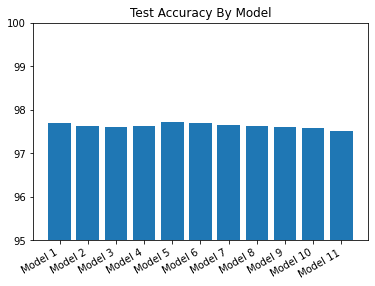

In [93]:
names = [f'Model {i+1}' for i in range(len(state_dicts))]
plt.bar(names, test_results)
plt.title("Test Accuracy By Model")
plt.ylim([95,100])
plt.xticks(rotation=30, ha='right')

Model: 6, Accuracy: 97.68


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

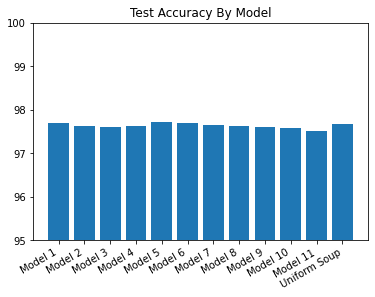

In [94]:
alphal = [1 / len(state_dicts) for i in range(len(state_dicts))]
model = get_model(state_dicts, alphal)
test_res = utils.test(loaders['test'], model, criterion)
print(f'Model: {6}, Accuracy: {test_res["accuracy"]}')
test_results.append(test_res["accuracy"])
names.append("Uniform Soup")
plt.bar(names, test_results)
plt.title("Test Accuracy By Model")
plt.ylim([95,100])
plt.xticks(rotation=30, ha='right')

In [95]:
ranked_candidates = [i for i in range(len(state_dicts))]
ranked_candidates.sort(key=lambda x: -val_results[x])

current_best = val_results[ranked_candidates[0]]
best_ingredients = ranked_candidates[:1]
for i in range(1, len(state_dicts)):
  # add current index to the ingredients
  ingredient_indices = best_ingredients \
    + [ranked_candidates[i]]
  alphal = [0 for i in range(len(state_dicts))]
  for j in ingredient_indices:
    alphal[j] = 1 / len(ingredient_indices)
  
  # benchmark and conditionally append
  model = get_model(state_dicts, alphal)
  test_res = utils.test(loaders['val'], model, criterion)
  current = test_res['accuracy']
  print(f'Models {ingredient_indices} got {current}% on validation.')
  if current > current_best:
    current_best = current
    best_ingredients = ingredient_indices


Models [5, 2] got 98.36% on validation.
Models [5, 3] got 98.36% on validation.
Models [5, 4] got 98.36% on validation.
Models [5, 6] got 98.38% on validation.
Models [5, 7] got 98.36% on validation.
Models [5, 1] got 98.36% on validation.
Models [5, 8] got 98.36% on validation.
Models [5, 9] got 98.32% on validation.
Models [5, 10] got 98.36% on validation.
Models [5, 0] got 98.4% on validation.


In [96]:
alphal = [0 for i in range(len(state_dicts))]
for j in best_ingredients:
  alphal[j] = 1 / len(best_ingredients)
model = get_model(state_dicts, alphal)
test_res = utils.test(loaders['test'], model, criterion)

test_results.append(test_res['accuracy'])

In [97]:
print(test_results)

[97.7, 97.62, 97.61, 97.63, 97.71, 97.7, 97.66, 97.63, 97.61, 97.58, 97.51, 97.68, 97.74]
